What did I use in this Notebook ?

* Permutation selectino , Mutual Importance  

* Stacking Classifier  , Voting Classifier  , Gradient Boosting 

* MultiLayer Perceptron 

* RepeatedKFold



# Packages

In [ ]:
!pip -q install mlxtend 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score


In [61]:
df=pd.read_csv("StressLevelDataset.csv")
df.head(3) 

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1


# EDA 

<Axes: >

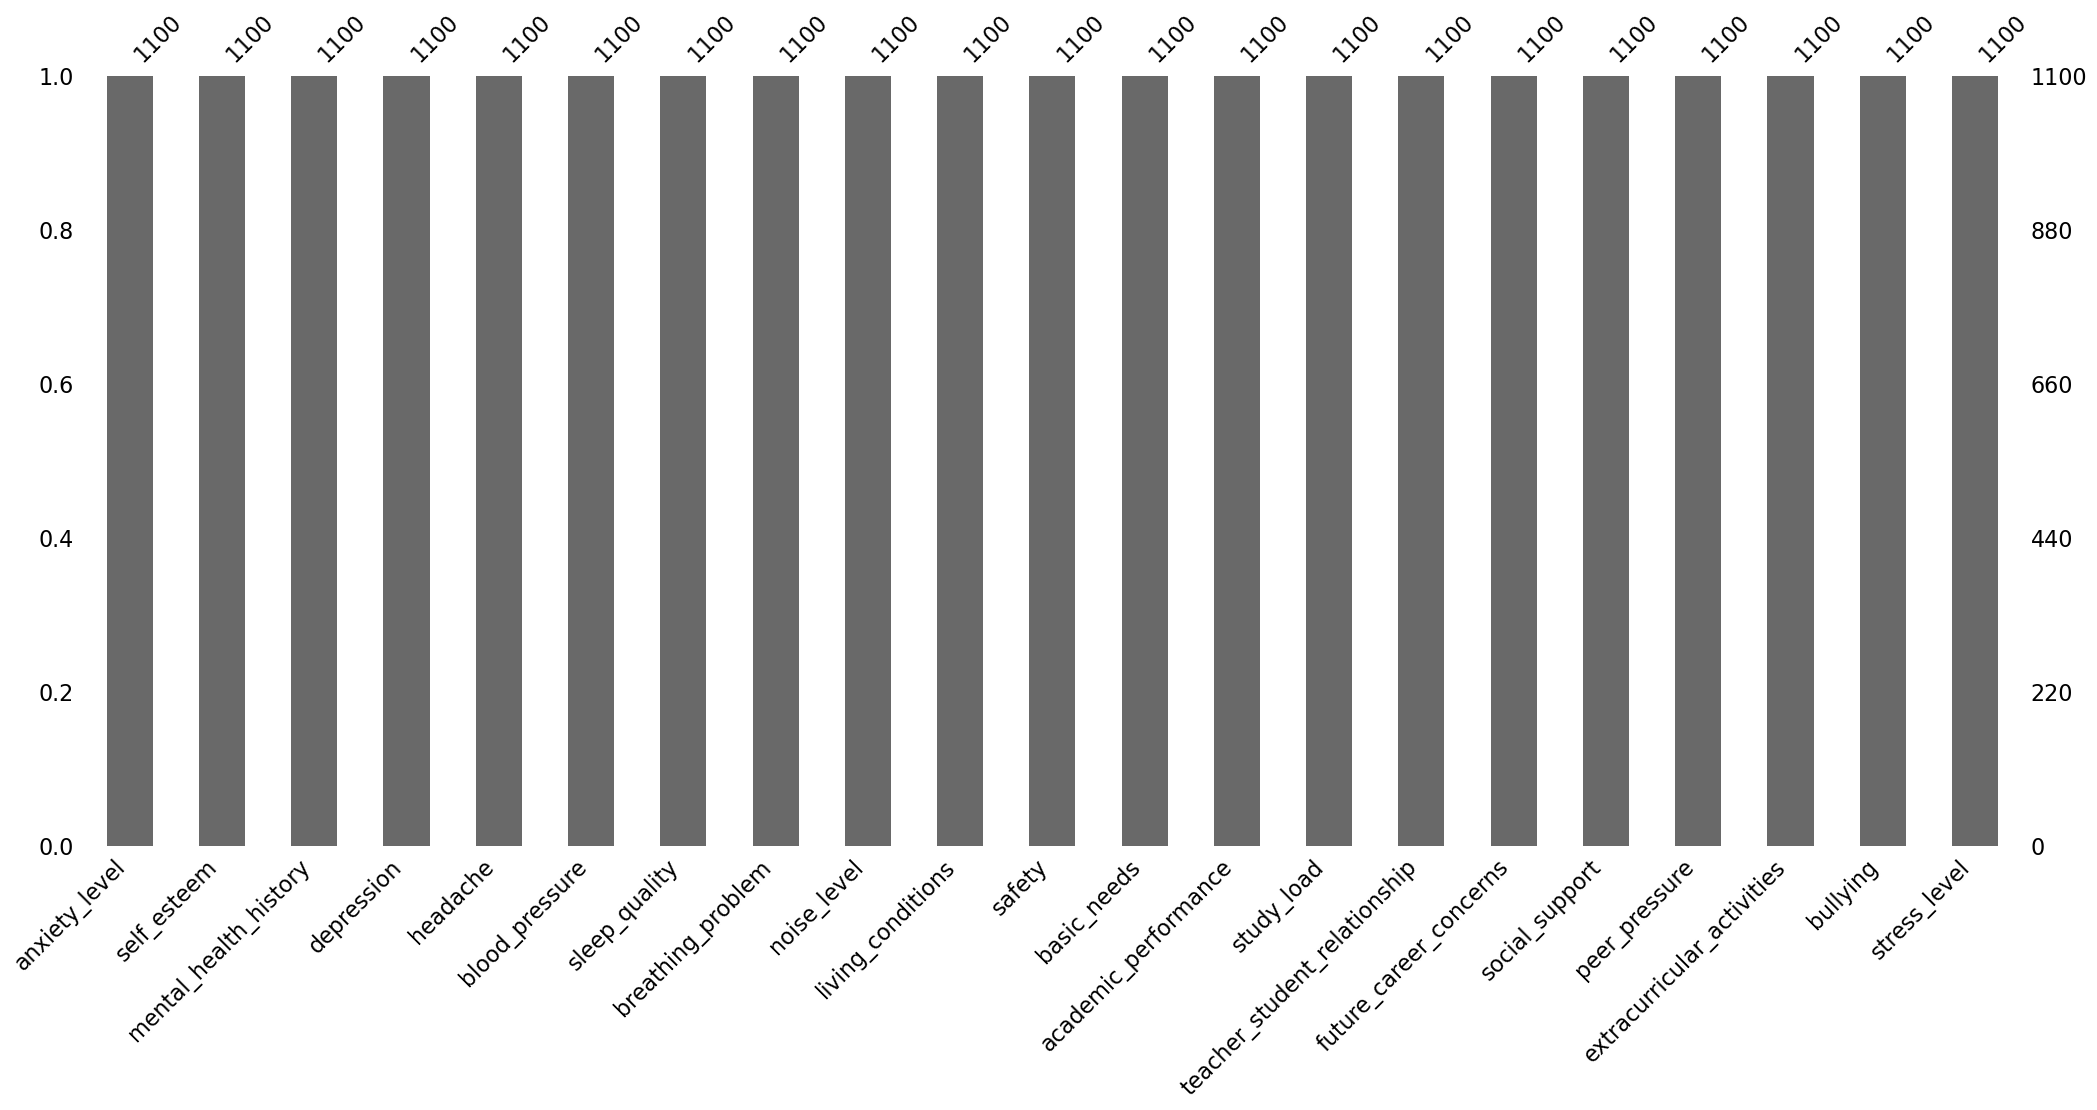

In [3]:
import missingno as msa
msa.bar(df)

In [4]:
print(f"stress_levels= {df.stress_level.unique()}") 
print(f"shape={df.shape}")

stress_levels= [1 2 0]
shape=(1100, 21)


In [5]:
df.dtypes.unique(), len(df.select_dtypes(include="int").columns)

(array([dtype('int64')], dtype=object), 21)

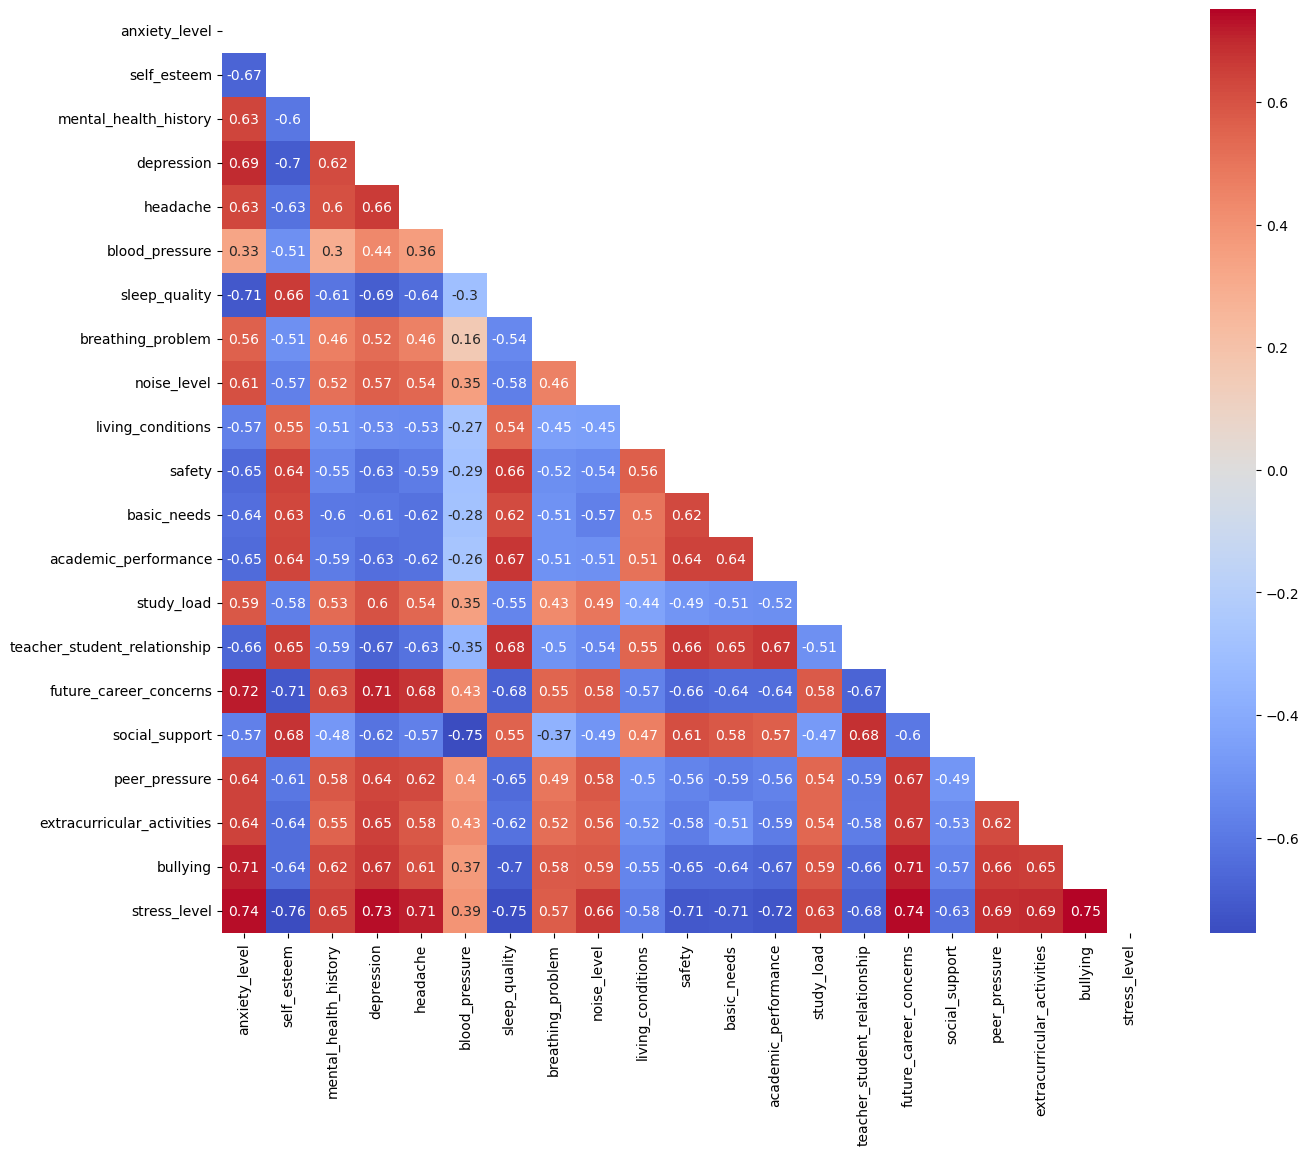

In [6]:

correlation =df.corr()

mask=np.triu(np.ones_like(correlation ,dtype=bool))

plt.figure(figsize=(15, 12)) 
sns.heatmap(correlation ,mask=mask,cmap="coolwarm" ,annot=True)

plt.show()

/var/folders/2z/v9qcn7fj709fx7gqfl91ww680000gn/T/ipykernel_80738/4211038582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.values, y=x.index ,palette="RdYlBu")


<Axes: ylabel='None'>

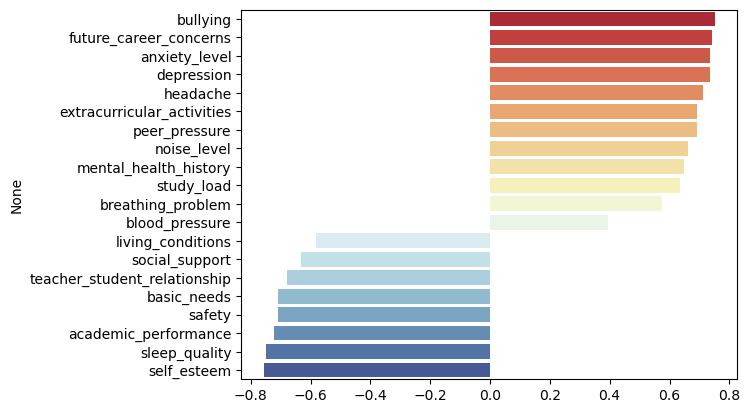

In [7]:
x=correlation["stress_level"].sort_values(ascending=False)
x=x.drop("stress_level")
sns.barplot(x=x.values, y=x.index ,palette="RdYlBu")

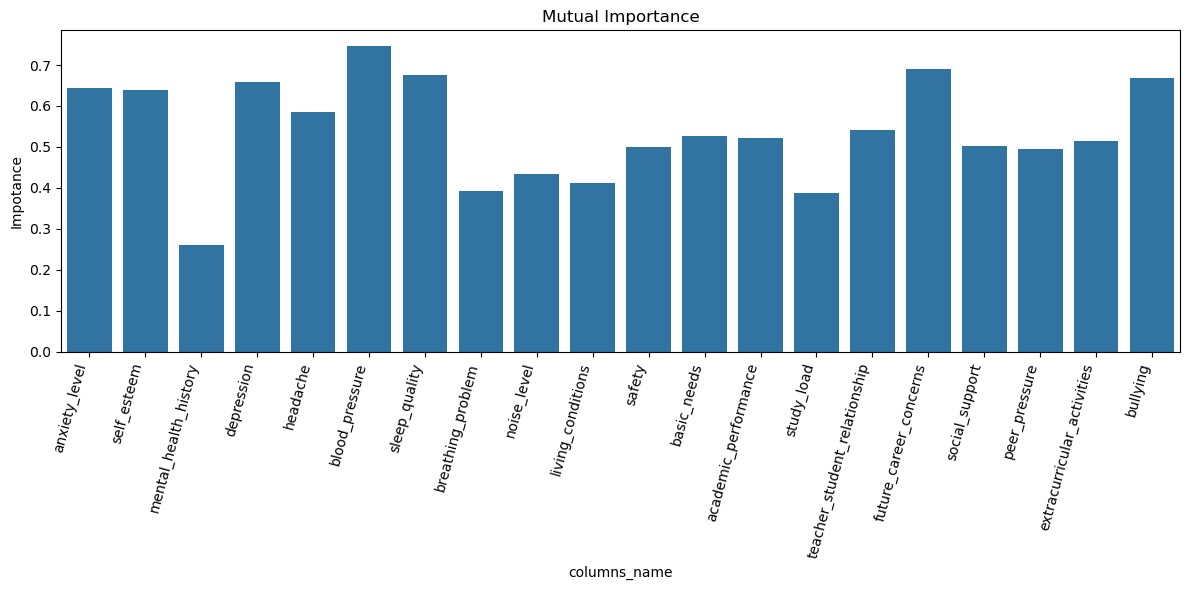

In [8]:
mi_importance=mutual_info_classif(df.drop(columns=['stress_level']),df['stress_level'] ,random_state=4)
#for col , score in zip(df.columns,mi_importance):
#    print(f" {score:.2f} , {col}")
x=df.drop(columns=['stress_level']).columns


Data_importance=pd.DataFrame({"columns_name":x,"Impotance":mi_importance})

Data_importance
plt.figure(figsize=(12,6))
sns.barplot(x=Data_importance['columns_name'],y=Data_importance['Impotance'])
plt.xticks(rotation=75, ha="right")
plt.title("Mutual Importance")
plt.tight_layout()

# Preprocessing 

In [106]:
df3=df.copy()
df3.columns

Index(['anxiety_level', 'self_esteem', 'mental_health_history', 'depression',
       'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem',
       'noise_level', 'living_conditions', 'safety', 'basic_needs',
       'academic_performance', 'study_load', 'teacher_student_relationship',
       'future_career_concerns', 'social_support', 'peer_pressure',
       'extracurricular_activities', 'bullying', 'stress_level'],
      dtype='object')

In [107]:
base_models = [
    ('gbc', GradientBoostingClassifier(n_estimators=300, random_state=44)),
    
]
meta_model=LogisticRegression(max_iter=400,C=0.9)

stack_model=StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

model55=GradientBoostingClassifier(n_estimators=300, random_state=44)

model3=LogisticRegression(max_iter=400,C=0.9)

In [107]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Put your models into a dictionary for easy looping
models = {

   "Model55": model55,

}

# Loop through models
for name, model in models.items():
    print(f"\nRunning SFS for {name} ...")
    
    sfs = SFS(
        model,
        k_features="best",      # best number of features
        forward=True,
        floating=False,
        scoring="accuracy",
        cv=RepeatedKFold(n_splits=2 ,n_repeats=2 ,random_state=42)
    )
    
    sfs.fit(x_train, y_train)
    
    # Print results
    print(f"{name} selected features: {sfs.k_feature_names_}")
    print(f"{name} CV score: {sfs.k_score_:.4f}")



Running SFS for Model55 ...
Model55 selected features: ('self_esteem', 'blood_pressure', 'breathing_problem', 'teacher_student_relationship', 'peer_pressure', 'bullying')
Model55 CV score: 0.9045

Running SFS for StackModel ...
StackModel selected features: ('blood_pressure', 'breathing_problem', 'social_support', 'peer_pressure')
StackModel CV score: 0.9039


In [108]:
final_features= [
'self_esteem',
 'mental_health_history',
 'blood_pressure',
 'sleep_quality',
 'social_support','stress_level'
]
df3 = df3[final_features]



In [109]:
print(df3.shape)
x=df3.drop(columns="stress_level")
y=df3['stress_level']
x.shape , y.shape
x_train ,x_test,y_train,y_test =train_test_split(x,y,test_size=0.3,random_state=42, stratify=y)
print(x_train.shape), print(y_test.shape), print(x_test.shape)




(1100, 6)
(770, 5)
(330,)
(330, 5)


(None, None, None)

# Building  Model

Stacking model (Gradient Boosting & Logistic Regresstion)

In [114]:
stack_model.fit(X_train,y_train)

stack_accuracy=stack_model.score(x_test , y_test)*100

print("Stacking Model Accuracy:",stack_accuracy)

scores=cross_val_score(stack_model,x_train,y_train,cv=5,scoring="accuracy")

print(f"cross validation for Stacking models {scores.mean()*100}")

Stacking Model Accuracy: 91.21212121212122
cross validation for Stacking models 89.87012987012986


Voting model


In [ ]:
from sklearn.ensemble import VotingClassifier

log=model3
sta=stack_model
gboost=model55

voting_clf=VotingClassifier(    

estimators=[
('log',log),('sta',sta),('gboost',gboost)
]

)
voting_clf.fit(X_train,y_train)
y_hat=voting_clf.predict(X_test )
acc_voting=accuracy_score(y_test,y_hat)*100
print(f"accuracy of the Voting model :{acc_voting}")


accuracy of the Voting model :90.9090909090909


In [47]:
from sklearn.model_selection import cross_val_score , RepeatedKFold

r=RepeatedKFold(n_repeats=3 ,n_splits=4 ,random_state=44)

score=cross_val_score (voting_clf,x_train,y_train ,cv=r)
print(f" cross validation of the Voting models :{score.mean()*100}")


 cross validation of the Voting models :88.91407599309153


MultiLayer Percepptron

In [103]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import   StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd



# 2. Train-test split


# 3. Scale features (important for MLP)
scalar=StandardScaler
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# 4. Build and train MLP
mlp = MLPClassifier(hidden_layer_sizes=(16, 32), activation="relu", solver="adam", max_iter=1000, random_state=12)
mlp.fit(x_train, y_train)

# 5. Evaluate
y_pred = mlp.predict(x_test)

accuracy_mlp=accuracy_score(y_test, y_pred)*100
print("Test Accuracy:", accuracy_mlp)


Test Accuracy: 91.51515151515152


In [121]:
from sklearn.inspection import permutation_importance
import numpy as np

# --- get correct feature names ---
try:
    feature_names = x_test.columns                # if DataFrame
except AttributeError:
    feature_names = [f"f{i}" for i in range(x_test.shape[1])]

# --- run permutation importance ---
result = permutation_importance(stack_model, x_test, y_test, n_repeats=10, random_state=42)
importance = result.importances_mean

# --- sort and display top 10 with names ---
indices = np.argsort(importance)[::-1]
print("Stacking Classifer Features")
for idx in indices[:10]:
    print(f"{feature_names[idx]}: {importance[idx]:.2f}")


Stacking Classifer Features
blood_pressure: 0.21
sleep_quality: 0.21
self_esteem: 0.10
mental_health_history: 0.05
social_support: 0.02


# Result

In [46]:
df=pd.DataFrame({"Accuracy_Prediction":[acc_voting,accuracy_mlp,stack_accuracy]}, index=["VotingClassifier","Multilayer perceptron","Stack_Classifier"])
df["Accuracy_Prediction"]=df["Accuracy_Prediction"].round(3)
df=df.reset_index().rename(columns={"index":"Model"})
df

,Model,Accuracy_Prediction
0,VotingClassifier,90.909
1,Multilayer perceptron,91.515
2,Stack_Classifier,91.212
